# Protein-like MSM building

Dependencies can be installed in a new conda environment with
`conda env create -f environment.yml`
or installed into an existing environment with
`conda env update --name <existing environment name> --file environment.yml`

# Load dependencies

In [1]:
import MDAnalysis as mda
import MDAnalysis.analysis.rms
import MDAnalysis.analysis.align
from MDAnalysis.analysis import diffusionmap
from MDAnalysis.analysis.distances import distance_array
import numpy as np
import tqdm.auto as tqdm
from deeptime.clustering import KMeans, KMeansModel
from matplotlib import pyplot as plt
from deeptime.decomposition import TICA
import copy
import pickle
import ray

In [214]:
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # white with alpha = 100%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # white with alpha = 100%
})

## Load DE Shaw trajectories

I'll be using the Trp-cage (2JOF) folding trajectory #2. This is 105 DCD files + a topology .mae, indexed as 0-104.

In [180]:
trajectory_base_path = '/Users/russojd/Research/desres_trajectories/DESRES-Trajectory_2JOF-0-protein 2/2JOF-0-protein'
n_traj_files = 105

traj_name = "2JOF-0-protein-{traj_idx:0>3d}.dcd"

dataset_label = 'coarser'

# MDAnalysis can't read the .mae
# topology_name = "2JOF-0-protein.mae"

# So instead, use this PDB I got from converting the .mae
topology_name = "2JOF.pdb"

model_name = '2JOF'

topology_path = f"{trajectory_base_path}/{topology_name}"
traj_paths = [f"{trajectory_base_path}/{traj_name.format(traj_idx=_idx)}" for _idx in range(n_traj_files)]

In [3]:
# Explicitly set the timestep here, since letting MDAnalysis infer it gives a wonky result.

# Each of my trajectory DCD files start 2e6 units apart
# The very first trajectory starts at 200 units
# The whole trajectory is 208µs, and all the trajectories are 1e6 units, so a unit is 200ps.

dt = 200

In [4]:
universe = mda.Universe(topology_path, traj_paths, dt=dt )

In [5]:
total_time_ps = len(universe.trajectory) * universe.trajectory.dt

print(f"Total trajectory time is {total_time_ps/1e6} µs")

Total trajectory time is 208.8 µs


## Prepare trajectory (align+center)

This aligns alpha-carbons on the provided reference topology, and spits out the result in `aligned_2JOF.dcd`. This only needs to be run once, to make that file.

In [6]:
ref_universe = mda.Universe(topology=topology_path)

# Trajectory preparation

In [7]:
# Stride the trajectory
stride = 1

rmsd_stride = 1

# tica_dims = 10

# The tIC that most closely corresponds to RMSD -- may change
tic_rmsd = 0

## Featurize trajectory

In the original Shaw publication, they featurized the folding transition with alpha-carbon RMSD.

[MDAnalysis RMSD documentation](https://www.mdanalysis.org/MDAnalysisTutorial/analysismodule.html#rmsd)

In [8]:
aligned = mda.Universe(topology_path, 'aligned_2JOF.dcd')
alpha_carbons = aligned.select_atoms('name CA')
initial_positions = alpha_carbons.positions.copy()

### Compute RMSD

#### Load saved

In [9]:
rmsd = np.load(f'rmsd_{model_name}.npz')['rmsd']

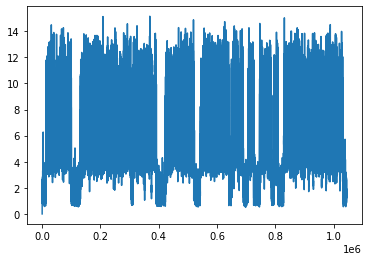

In [10]:
plt.plot(rmsd)

### Get instantaneous positions of all alpha-carbons

### Get pairwise alpha-carbon RMSD

https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/rmsd.html#RMSD-of-a-Universe-with-multiple-selections

#### Load saved

In [11]:
R = pickle.load(open('rmsd.obj', 'rb'))

In [12]:
R.rmsd.shape

/Users/russojd/opt/anaconda3/envs/jupyter/lib/python3.9/site-packages/MDAnalysis/analysis/rms.py:710: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


(104400, 23)

### Residue-residue minimum distance

From “Assessing the accuracy and bias of Markov state models”:

> Featurization was done with "all minimal residue-residue distances (calculated as the closest distance between the heavy atoms of two residues separated in sequence by at least two neighboring residues)”

In [13]:
n_residues = len(aligned.residues)
all_residue_ids = range(1, 1+n_residues)

nearby_residue_ids = {}

for i in range(n_residues):
    
    partner_residues = [aligned.residues[i-1].resid, aligned.residues[i].resid, aligned.residues[(i+1)%n_residues].resid]
    
# for residue in aligned.residues:
    # adjacent_residues = [residue.resid-1, residue.resid, residue.resid+1]
    # if adjacent_residues[0] < 0:
        # adjacent_residues = aligned.residues[-1].resid
        
    _nearby_residues = np.setdiff1d(all_residue_ids, partner_residues)
    
    nearby_residue_ids[all_residue_ids[i]] = _nearby_residues

In [14]:
nearby_residue_ids

{1: array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 2: array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 3: array([ 1,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 4: array([ 1,  2,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 5: array([ 1,  2,  3,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 6: array([ 1,  2,  3,  4,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 7: array([ 1,  2,  3,  4,  5,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 8: array([ 1,  2,  3,  4,  5,  6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 9: array([ 1,  2,  3,  4,  5,  6,  7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 10: array([ 1,  2,  3,  4,  5,  6,  7,  8, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 11: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 13, 14, 15, 16, 17, 18, 19, 20]),
 12: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16, 17, 18, 19, 20]),
 13: array([ 1,  2,  3,  

In [16]:
print(stride)

selections = {residue.resid:aligned.select_atoms(f'resnum {residue.resid} and not type H') for residue in aligned.residues}

1


In [47]:
@ray.remote
def analyze_frame(frame, i, aligned_residues, selections, nearby_residue_ids, stride):
    
    pairs = []
    
    for residue in aligned_residues:
        
        selection_from = selections[residue.resid]
        
        # Get minimum distances to each of the nearby residues (separated by at least 1 residue index)
        for nearby_residue_id in nearby_residue_ids:

            selection_to  = selections[nearby_residue_id] #= aligned.select_atoms(f'resnum {nearby_residue_id} and name CA')
            
            residue_distances = MDAnalysis.analysis.distances.distance_array(selection_from.positions, selection_to.positions, backend='openmp')
            
            min_dist = np.min(residue_distances)
            
            pairs.append([min_dist, (residue.resid-1, nearby_residue_id-1)])
            
    return i//stride, pairs
            # distance_matrix[i//stride, residue.resid-1, nearby_residue_id-1] = min_dist
            # return (i//stride, residue.resid-1, nearby_residue_id-1), min_dist

Do this in parallel because it's mega slow

In [32]:
ray.init(num_cpus=4)

2022-02-16 09:23:01,757	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:6379',
 'object_store_address': '/tmp/ray/session_2022-02-16_09-22-54_947616_36510/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-16_09-22-54_947616_36510/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-02-16_09-22-54_947616_36510',
 'metrics_export_port': 64104,
 'gcs_address': '127.0.0.1:59326',
 'node_id': '9443c149ac839cbf49e533b2741a38432bf08f3773263fe75f503121'}

(raylet) /Users/russojd/opt/anaconda3/envs/protein-like_msm/lib/python3.9/site-packages/ray/dashboard/agent.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(raylet)   if LooseVersion(aiohttp.__version__) < LooseVersion("4.0.0"):


In [55]:
distance_matrix = np.full(shape=(len(aligned.trajectory)//stride, n_residues, n_residues), fill_value=np.nan)

task_ids = []
max_inflight = 10
chunk_size=100
doing_chunk = False

for i, frame in tqdm.tqdm(enumerate(aligned.trajectory), total=len(aligned.trajectory), desc='Submitting jobs'):

    if not i%stride == 0:
        continue
        
    # if i > 1000: break
        
#     if len(task_ids) > max_inflight:
    
#         # The number that need to be ready before we can submit more
#         num_ready = i - max_inflight
#         ray.wait(task_ids, num_returns=num_ready)
                    
    _id = analyze_frame.remote(frame, i, aligned.residues, selections, nearby_residue_ids, stride)
    
    task_ids.append(_id)
    
with tqdm.tqdm(
    total=len(task_ids), desc="Retrieving discretized trajectories"
) as pbar:
    while task_ids:
        result_batch_size = 100
        result_batch_size = min(result_batch_size, len(task_ids))

        # Returns the first ObjectRef that is ready, with a 20s timeout
        finished, task_ids = ray.wait(
            task_ids, num_returns=result_batch_size, timeout=20
        )
        results = ray.get(finished)
        
        for frame_idx, _dists in results:
            for min_dist, (from_residue, to_residue) in _dists:
                distance_matrix[frame_idx, from_residue, to_residue] = min_dist
            
            pbar.update(1)

Submitting jobs:   0%|          | 0/1044000 [00:00<?, ?it/s]

Retrieving discretized trajectories:   0%|          | 0/1044000 [00:00<?, ?it/s]

#### Load saved

In [17]:
distance_matrix = np.load('distance_matrix.npz')['distance_matrix']

In [18]:
distance_matrix.shape

(1044000, 20, 20)

In [19]:
# Get rid of the nan terms corresponding to self-distance or adjacent-distrances

reduced_distance_matrix = np.full(shape=(distance_matrix.shape[0], n_residues, n_residues-3), fill_value=np.nan)

for residue, partners in nearby_residue_ids.items():
    
    reduced_distance_matrix[:, residue-1] = distance_matrix[:, residue-1, partners-1]

In [20]:
reduced_distance_matrix.shape

(1044000, 20, 17)

In [25]:
assert not np.isnan(reduced_distance_matrix).any()

## Dimensionality reduction

At a 10ns MSM lag time (i.e. 50-frames, since each frame is 200ps), the dimensionality reduction was
- commute tICA
- 10ns tICA lag
- 10 tICs
- 200 microstates

In [27]:
_map_type = 'commute_map'
lag_steps = 50
n_tics = 10
n_clusters = 1000
msm_lag_steps = 50

In [28]:
unrolled_distances = reduced_distance_matrix.reshape((reduced_distance_matrix.shape[0], -1))

In [29]:
reduced_distance_matrix.shape, unrolled_distances.shape

((1044000, 20, 17), (1044000, 340))

### Calculate fresh

In [30]:
tica = TICA(lagtime=lag_steps, dim=n_tics, scaling=_map_type)

In [31]:
tica_model = tica.fit_fetch(unrolled_distances, verbose=True)

In [32]:
projection = tica_model.transform(unrolled_distances)

In [49]:
np.savez(f'{dataset_label}_tica', tica=tica, tica_model=tica_model, projection=projection)

### Load saved

In [50]:
_tica = np.load(f'{dataset_label}_tica.npz', allow_pickle=True)
tica = _tica['tica']
tica_model = _tica['tica_model']
projection = _tica['projection']

In [35]:
projection.shape

(1044000, 10)

### Visualize tIC 0 and RMSD

Visually compare the tIC projection and the RMSD. If the tIC projection looks weird, try looking at some others.

tIC 0 PROBABLY maps to RMSD (i.e., it usually does)

In [36]:
tic_rmsd = 0

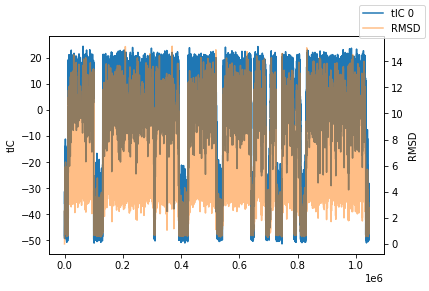

In [217]:
fig, ax = plt.subplots()

ax.plot(projection[:, tic_rmsd], label=f'tIC {tic_rmsd}', color='tab:blue')
ax.set_ylabel('tIC')

ax2 = ax.twinx()
ax2.plot(rmsd[::1], label='RMSD', alpha=0.5, color='tab:orange')
ax2.set_ylabel('RMSD')

fig.legend()

## Discretize trajectory

### Aggregate clustering

We'll just do a simple k-means clustering on the RMSDs.

[Deeptime k-means clustering documentation](https://deeptime-ml.github.io/latest/notebooks/clustering.html)

In [299]:
# Number of clusters for k-means
# n_clusters = 1000

In [89]:
# Initialize the estimator
# Perform the clustering

kmeans_estimator = KMeans(
    n_clusters=n_clusters,
    # init_strategy='uniform',
    max_iter=1000,
    fixed_seed=1337,
    n_jobs=4,
    progress=tqdm.tqdm
)

In [90]:
clustering = kmeans_estimator.fit(projection).fetch_model()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [93]:
pickle.dump(clustering, open('clustering.obj', 'wb'))
pickle.dump(kmeans_estimator, open('kmeans_estimator.obj', 'wb'))

In [92]:
# Discretize the trajectory
discrete_trajectory = clustering.transform(projection)

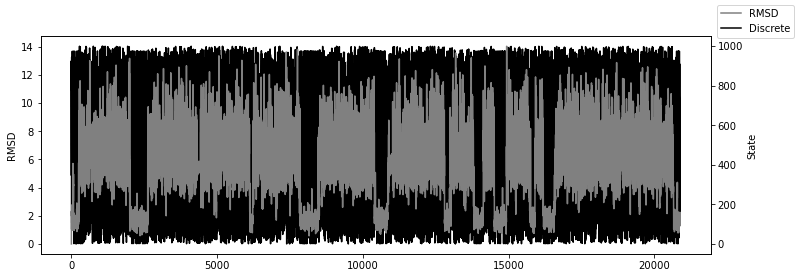

In [96]:
# Plot the RMSDs and discrete trajectory
fig, rmsd_ax = plt.subplots(1,1)

discrete_ax = rmsd_ax.twinx()

discrete_ax.plot(discrete_trajectory[::50], color='k', label='Discrete')
discrete_ax.set_ylabel('State')

rmsd_ax.plot(rmsd[::rmsd_stride*50], color='gray', label='RMSD')
rmsd_ax.set_ylabel('RMSD')


rmsd_ax.set_zorder(10)
rmsd_ax.patch.set_visible(False)

fig.legend()
fig.set_size_inches(12,4)

### Stratified clustering

Here, I want to divide up RMSD uniformly, and then cluster within each RMSD-bin.

In [38]:
# Now, cluster within each of those.
# clusters_per_strat = 10
n_strat_bins = 50
clusters_per_strat = n_clusters // n_strat_bins

rmsd_bins = np.linspace(1, 13, n_strat_bins)
rmsd_bins

array([ 1.        ,  1.24489796,  1.48979592,  1.73469388,  1.97959184,
        2.2244898 ,  2.46938776,  2.71428571,  2.95918367,  3.20408163,
        3.44897959,  3.69387755,  3.93877551,  4.18367347,  4.42857143,
        4.67346939,  4.91836735,  5.16326531,  5.40816327,  5.65306122,
        5.89795918,  6.14285714,  6.3877551 ,  6.63265306,  6.87755102,
        7.12244898,  7.36734694,  7.6122449 ,  7.85714286,  8.10204082,
        8.34693878,  8.59183673,  8.83673469,  9.08163265,  9.32653061,
        9.57142857,  9.81632653, 10.06122449, 10.30612245, 10.55102041,
       10.79591837, 11.04081633, 11.28571429, 11.53061224, 11.7755102 ,
       12.02040816, 12.26530612, 12.51020408, 12.75510204, 13.        ])

In [51]:
rmsd.shape, projection.shape

((1044000,), (1044000, 10))

Text(0, 0.5, 'RMSD')

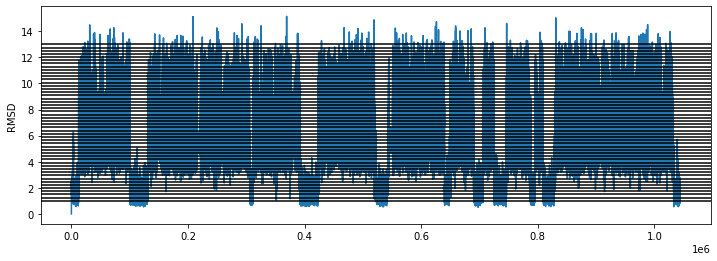

In [216]:
plt.plot(rmsd[::rmsd_stride])
plt.gcf().set_size_inches(12,4)

[plt.axhline(rmsd_bin, color='k') for rmsd_bin in rmsd_bins];
plt.ylabel('RMSD')

In [41]:
bin_boundaries = np.concatenate([[-np.inf], rmsd_bins, [np.inf]])

all_clusters = []

for bin_lower, bin_upper in tqdm.tqdm(zip(bin_boundaries[:-1], bin_boundaries[1:]), total=len(bin_boundaries)-1):

    kmeans_estimator = KMeans(
        n_clusters=clusters_per_strat,
        max_iter=1000,
        fixed_seed=1337,
        n_jobs=4,
        progress=tqdm.tqdm
    )
    
    # Get the points in this bin
    points_in_bin = np.argwhere((rmsd[::rmsd_stride] >= bin_lower) & (rmsd[::rmsd_stride] < bin_upper)).flatten()
    
    clustering = kmeans_estimator.fit(projection[points_in_bin]).fetch_model()
    
    all_clusters.append(copy.deepcopy(clustering))

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [42]:
combined_kmeans_centers = np.concatenate([x._cluster_centers for x in all_clusters])

all_cluster = KMeansModel(combined_kmeans_centers, metric='euclidean')

In [43]:
discrete_stratified = all_cluster.transform(projection)

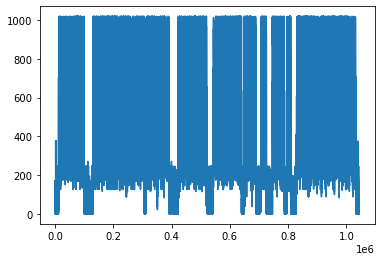

In [44]:
plt.plot(discrete_stratified)

In [53]:
discrete_trajectory = discrete_stratified
clustering = all_cluster

# Build MSM

## Load necessary trajectory data

For now, manually run 
1. Up to Trajectory Preparation
2. The "Load Saved" sections within Trajectory preparation
3. Dimensionality reduction: Load Saved
4. Discretize trajectory

before running this. Can probably save all the intermediate results in one `npz` eventually.

## Construct MSM object

Build with the lag time specified before, and enforce reversibility.

In [64]:
from deeptime.markov import TransitionCountEstimator, TransitionCountModel
from deeptime.markov.msm import MaximumLikelihoodMSM, MarkovStateModel

In [55]:
lag = msm_lag_steps
print(msm_lag_steps)
count_model = TransitionCountEstimator(lag, 'sliding').fit_fetch(discrete_trajectory)
asymm_msm = MaximumLikelihoodMSM(reversible=True).fit_fetch(count_model.submodel_largest())

50


### Symmetrize

Add the count matrix to its transpose, to get an equal number of counts in/out of states. Then construct an MSM from that symmetrized count matrix.

In [65]:
symmetric_count_matrix = count_model.count_matrix + count_model.count_matrix.T
symmetric_count_model = TransitionCountModel(symmetric_count_matrix, 
                                             lagtime=lag, counting_mode='sliding')

symm_msm =  MaximumLikelihoodMSM(reversible=True).fit_fetch(
    symmetric_count_model.submodel_largest())

msm = symm_msm

## Define folded/unfolded/intermediate states

These are manually defined in the space of the tIC that maps to RMSD, mostly because it's fairly easy to pick out reasonable thresholds by eye.

In [66]:
unfolded_thresh = 10 #0.9
folded_thresh = -35 #-1.89

unfolded = np.argwhere(clustering.cluster_centers[:, tic_rmsd].flatten() > unfolded_thresh).flatten()
folded = np.argwhere(clustering.cluster_centers[:, tic_rmsd].flatten() < folded_thresh).flatten()

# unfolded_thresh = 1.6
# folded_thresh = -1.89
# unfolded = np.argwhere(clustering.cluster_centers[:, tic_rmsd].flatten() > unfolded_thresh).flatten()
# folded = np.argwhere(clustering.cluster_centers[:, tic_rmsd].flatten() < folded_thresh).flatten()
# len(unfolded), len(folded)

In [68]:
# Sort by the rmsd-like tic

active_states = symmetric_count_model.connected_sets()[0]
cluster_sort_order = np.argsort(clustering.cluster_centers[active_states, tic_rmsd])

intermediate = np.setdiff1d(active_states, np.concatenate([folded, unfolded]))

In [69]:
len(unfolded), len(folded), len(intermediate)

(458, 102, 460)

### Visualize results of MSM

Note that in the plot below, the histogram may lie directly below the stationary distribution.

In [70]:
# Get the histogram in each bin from the full trajectory
hist_bins, hist_counts = np.unique(discrete_trajectory, return_counts=True)
hist_counts = hist_counts/sum(hist_counts)

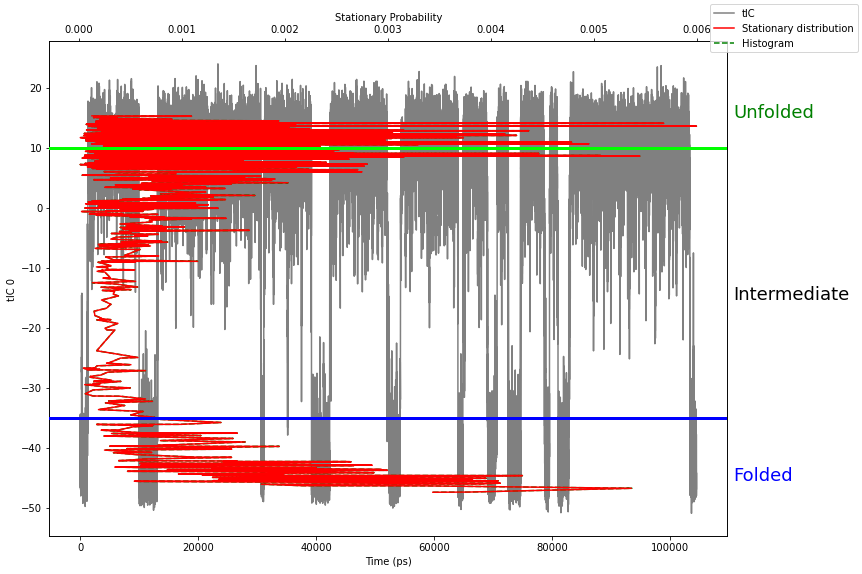

In [215]:
# Plot the RMSDs and discrete trajectory
fig, tic_ax = plt.subplots(1,1)
# rmsd_ax = tic_ax.twinx()

_subsample = 10

# rmsd_ax.plot(rmsd, color='gray', label='RMSD')
tic_ax.plot(projection[:, tic_rmsd][::_subsample], color='gray', label='tIC')
tic_ax.set_ylabel(f'tIC {tic_rmsd}')

# discrete_ax.plot(discrete_trajectory[::_subsample], color='k', label='Discrete')
# discrete_ax.set_ylabel('State')

tic_ax.set_xlabel('Time (ps)')

stationary_ax = tic_ax.twiny()
stationary_ax.plot(
    msm.stationary_distribution[cluster_sort_order],
    clustering.cluster_centers[cluster_sort_order, tic_rmsd],
    color='red',
    label='Stationary distribution'
)
stationary_ax.set_xlabel('Stationary Probability')

stationary_ax.plot(
    hist_counts[cluster_sort_order],
    clustering.cluster_centers[hist_bins.astype(int)][cluster_sort_order, tic_rmsd].flatten(),
    color='green',
    linestyle='--',
    label='Histogram',
    zorder=-5
)

stationary_ax.axhline(unfolded_thresh, color='lime', linewidth=3, zorder=5)
stationary_ax.axhline(folded_thresh, color='b', linewidth=3, zorder=5)

unfolded_label_y = unfolded_thresh*1.5
tic_ax.text(len(projection[::_subsample])*1.06, unfolded_label_y, 
            'Unfolded', color='green', fontsize=18)
folded_label_y = folded_thresh*1.3
tic_ax.text(len(projection[::_subsample])*1.06, folded_label_y, 
            'Folded', color='blue', fontsize=18)

tic_ax.text(len(projection[::_subsample])*1.06, (unfolded_label_y + folded_label_y)/2, 
            'Intermediate', color='black', fontsize=18)

fig.legend()
fig.set_size_inches(12,8)
fig.tight_layout()

### Plot potential and committor

Text(0, 0.5, '-$\\ln( P^{equil} )$')

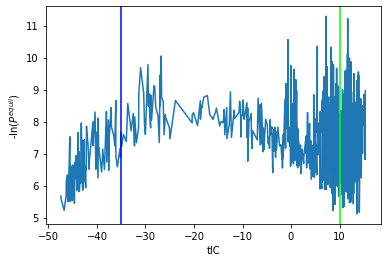

In [222]:
potential = -np.log(msm.stationary_distribution)

plt.plot(
    clustering.cluster_centers[cluster_sort_order, tic_rmsd],
    potential[cluster_sort_order])

plt.axvline(folded_thresh, color='b')
plt.axvline(unfolded_thresh, color='lime')

plt.xlabel('tIC')
plt.ylabel('-$\\ln( P^{equil} )$')

Text(0, 0.5, '-$\\ln( P^{equil} )$')

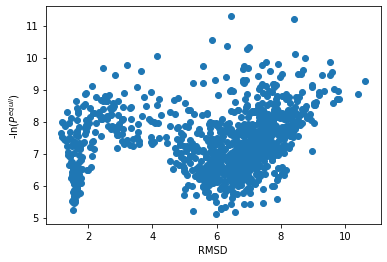

In [221]:
potential = -np.log(msm.stationary_distribution)

plt.scatter(
    avg_state_rmsds[cluster_sort_order],
    potential[cluster_sort_order])

# plt.axvline(folded_thresh, color='b')
# plt.axvline(unfolded_thresh, color='lime')

plt.xlabel('RMSD')
plt.ylabel('-$\\ln( P^{equil} )$')

Text(0.5, 0, 'tIC 0')

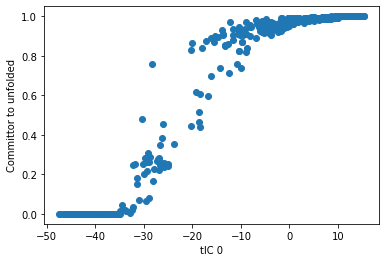

In [225]:
committors = msm.committor_forward(folded, unfolded)

committor_sort = np.argsort(committors)

plt.scatter(clustering.cluster_centers[committor_sort, tic_rmsd], committors[committor_sort])

plt.ylabel('Committor to unfolded')
plt.xlabel('tIC 0')

Text(0.5, 0, 'RMSD')

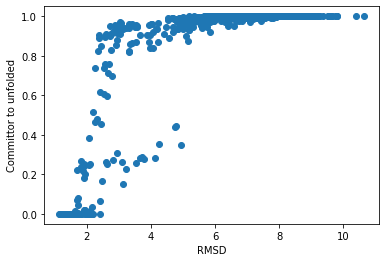

In [224]:
committors = msm.committor_forward(folded, unfolded)

committor_sort = np.argsort(committors)

plt.scatter(avg_state_rmsds[cluster_sort_order], committors[committor_sort])

plt.ylabel('Committor to unfolded')
plt.xlabel('RMSD')

### Save the model

In [76]:
mfpt_folding = msm.mfpt(unfolded.flatten(), folded.flatten())

In [77]:
mfpt_unfolding = msm.mfpt(folded.flatten(), unfolded.flatten())

In [78]:
mfpt_folding, mfpt_unfolding # Folding time, in units of the input trajectory

(51138.754251981, 11599.601489364708)

In [79]:
universe.trajectory.dt

200

In [80]:
mfpt_folding, mfpt_unfolding

print(f"Folding time: {mfpt_folding * universe.trajectory.dt * stride / 1000:.2f} ns")
print(f"Folding steps: {mfpt_folding :.0f} steps\n")

print(f"Unfolding time: {mfpt_unfolding * universe.trajectory.dt * stride  / 1000:.2f} ns")
print(f"Unfolding steps: {mfpt_unfolding :.0f} steps")
# ~500 steps @ 200ps/step = 0.1µs
# These MFPTs seem super high?

Folding time: 10227.75 ns
Folding steps: 51139 steps

Unfolding time: 2319.92 ns
Unfolding steps: 11600 steps


In [81]:
208/20 # Ballpark µs/transition

10.4

In [181]:
np.savez(f'{dataset_label}_transition_matrix_ernesto_symm', transition_matrix=msm.transition_matrix,
         states_unfolded = unfolded,
         states_folded = folded,
         cluster_centers = clustering.cluster_centers,
         mfpt_folding = mfpt_folding,
         mfpt_unfolding = mfpt_unfolding,
         msm=msm
         )

# Coarse-graining

I want to come up with a physically meaningful coarse-graining scheme here. That could look something like:
- Binning along RMSD
- Something hierarchical

I think for now binning along RMSD is probably an easy way to do it.

Committor is probably meaningful too, but it would require knowing the committors, which is the point of building the model. I.e., it wouldn't translate well to analyzing simulated data, it's cheating.

## Coarse-graining in RMSD

The idea here is that I can identify a set of coarse states by clustering on the RMSDs of the fine states.

To do this, I need to:
1. Get structures associated with each tIC cluster
2. Get average RMSD of those structures, to assign each fine cluster an RMSD value
3. Group those by clustering on them

In [83]:
rmsd[::rmsd_stride].shape, discrete_trajectory.shape

((1044000,), (1044000,))

### Compute average fine-state RMSDs

In [84]:
n_states = msm.transition_matrix.shape[0]

avg_state_rmsds = np.full(shape=n_states, fill_value=np.nan)

for state in range(n_states):
    
    idxs_in_state = np.argwhere(discrete_trajectory == state).flatten()
    
    rmsds = rmsd[::rmsd_stride][idxs_in_state]
    
    avg_state_rmsds[state] = np.mean(rmsds)
    
rmsd_sort_order = np.argsort(avg_state_rmsds).flatten()

Text(0.5, 0, 'Average fine-state RMSD')

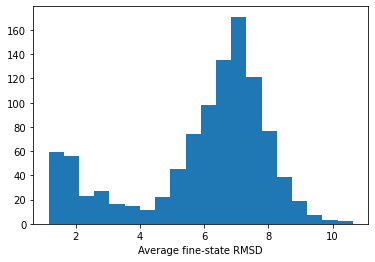

In [226]:
plt.hist(avg_state_rmsds, bins=20)
plt.xlabel('Average fine-state RMSD')

Text(0.5, 0, 'RMSD from folded structure')

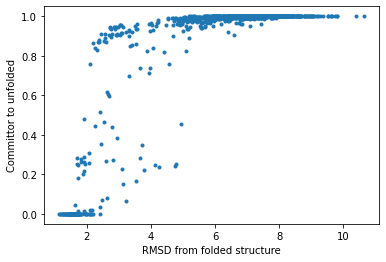

In [86]:
plt.plot(avg_state_rmsds, msm.committor_forward(folded, unfolded), '.')

plt.ylabel('Committor to unfolded')
plt.xlabel('RMSD from folded structure')

Text(0, 0.5, '-$\\ln( P^{equil} )$')

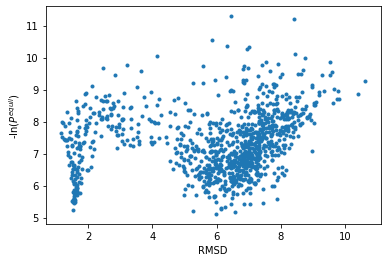

In [87]:
potential = -np.log(msm.stationary_distribution)

plt.plot(
    avg_state_rmsds[rmsd_sort_order],
    potential[rmsd_sort_order], '.')

# plt.axvline(folded_thresh)
# plt.axvline(unfolded_thresh)

plt.xlabel('RMSD')
plt.ylabel('-$\\ln( P^{equil} )$')

#### Failed attempt at heatmap

In [498]:
msm.stationary_distribution

# Each state has a value in the stationary distribution, and a tIC 1 and tIC 2 value
# So for each cluster, x/y are the tIC 1 / tIC 2, and z = stationary

array([0.00129843, 0.00033622, 0.0004665 , ..., 0.00029312, 0.00029312,
       0.00028737])

In [499]:
potential_data = np.vstack([
    msm.stationary_distribution,
    clustering.cluster_centers[:,0],
    clustering.cluster_centers[:,1],
])
potential_data.shape

(3, 1020)

### Cluster on fine-state RMSDs

#### Intermediates

For the intermediates, cluster into coarse-clusters on their average RMSDs.

We will manually assign the folded/unfolded states into their own coarse states.

In [182]:
n_coarse_clusters = 100

coarse_kmeans_estimator = KMeans(
    n_clusters=n_coarse_clusters,
    # init_strategy='uniform',
    max_iter=1000,
    fixed_seed=1337,
    n_jobs=4,
    progress=tqdm.tqdm
)

In [183]:
# This builds a model which maps an RMSD to a cluster

coarse_clustering = coarse_kmeans_estimator.fit_fetch(avg_state_rmsds[intermediate])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [184]:
# Now we assign clusters to all the state RMSDs

coarse_assignments = coarse_clustering.transform(avg_state_rmsds[intermediate])
coarse_assignments

array([76, 20, 20, 20, 20,  7,  7, 20, 17, 66,  7, 81, 66, 37, 29, 74, 57,
       17, 81,  7, 84,  2, 57, 81,  7, 57, 80, 92, 88, 75,  2, 74, 29,  2,
       38, 80, 16, 29, 49, 84, 75, 16, 64,  9, 37, 75, 10, 26,  2, 70, 72,
       69, 61, 29, 72, 52, 98, 38, 72, 61, 21, 10, 69, 72, 61, 70, 92, 68,
       64, 49, 70, 49, 42, 27,  0, 70, 70, 32,  9, 49, 10, 55, 21, 10, 22,
       12, 21, 13, 40,  9, 21,  4, 56, 22, 16, 59, 22, 53, 13, 52, 55,  4,
       59, 77, 87, 68, 55, 62, 27, 67, 19, 19, 56, 12, 62, 27, 55,  3, 63,
       27,  4, 52,  4, 90, 88, 40, 65, 90, 77, 68, 21, 58, 28,  0, 79, 39,
       58, 12, 24, 87, 33, 39, 67, 55, 99, 65, 24,  0, 85, 41,  5,  0, 78,
       79, 26, 53, 78, 28,  5, 79, 78, 56,  0, 87, 24, 90, 42, 40,  5, 78,
        3, 41, 40, 22, 67, 41, 82, 67, 36, 99, 12,  5, 69, 58, 53, 97, 13,
       39, 88, 24, 88, 19, 30, 54,  5,  3, 41, 12, 56, 13,  5, 79, 82, 26,
       60, 40, 88, 27, 87, 65, 28, 40, 36, 88, 68,  3, 54, 41, 88, 79, 28,
       67, 54, 78, 27, 82

#### Folded, unfolded

In [185]:
# Number of clusters in the folded/unfolded states (each)
n_coarse_target_clusters = 50

coarse_macrostate_assignments = {}
coarse_macrostate_clusters = {}

for macrostate, label in zip([folded, unfolded], ['folded', 'unfolded']):
    
    coarse_target_kmeans_estimator = KMeans(
        n_clusters=n_coarse_target_clusters,
        # init_strategy='uniform',
        max_iter=1000,
        fixed_seed=1337,
        n_jobs=4,
        progress=tqdm.tqdm
    )
    
    coarse_macrostate_clustering = coarse_target_kmeans_estimator.fit_fetch(
        avg_state_rmsds[macrostate]
    )
    coarse_macrostate_clusters[label] = copy.deepcopy(coarse_macrostate_clustering)
    
    coarse_macrostate_assignments[label] = coarse_target_kmeans_estimator.transform(
        avg_state_rmsds[macrostate]
    )
    
print(coarse_macrostate_assignments)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'folded': array([ 0, 38, 25, 20, 43, 27, 38, 22, 33, 14,  8, 48, 31, 14, 43, 34, 15,
       30,  6, 45, 33, 37,  4,  0, 15, 18, 39, 48,  3, 11, 22, 24, 49,  8,
       27, 36, 12, 37, 32, 32, 41, 18, 18, 47,  3, 32,  8, 41,  6, 23, 39,
       47, 11, 16, 41, 11, 19, 37, 41, 16, 23, 41, 32, 47, 47, 37, 47, 32,
       46, 23, 16, 26, 49, 39, 44, 10, 47, 42, 13,  1, 41, 24, 47,  5, 40,
        6, 11, 44,  5, 24, 11, 28,  9, 17, 29,  9, 13,  2, 35, 26, 21,  7],
      dtype=int32), 'unfolded': array([12,  7,  1, 31, 24, 31,  7,  7,  7,  7, 33,  7, 24,  4, 48, 12, 24,
        7, 24, 12,  1, 17, 31, 24, 31, 46,  4, 29, 12, 31, 19,  7, 24, 17,
       41, 24, 31, 29, 31, 12, 31, 48,  4,  1, 29, 24, 31,  4, 39, 31,  4,
       12, 31,  4, 48,  4,  6, 17, 12, 31, 48, 29, 17, 31, 48, 12, 29, 21,
        4, 48, 12,  1,  4, 48, 48, 38, 36, 39, 17, 15, 29,  1, 17, 48, 17,
       14,  8, 34, 17, 39, 34,  1, 17, 12,  1, 21,  6, 17, 48, 46, 48, 46,
       46, 34, 48, 14, 36, 46, 17, 36, 17, 45, 48, 14, 1

It's not necessary to merge these clusters, because I'm not actually re-discretizing or anything based on them.

Once I know what coarse cluster a fine cluster maps into, I can just assign it to that.

### Define coarse mapping

In [186]:
# This defines a mapping from <intermediate state> -> <coarse state ID>
coarse_mapping = {}

for i, state in enumerate(intermediate):
    
    avg_state_rmsd = avg_state_rmsds[state]
    coarse_state = coarse_assignments[i]
    
    # coarse_state = coarse_clustering.transform(np.array(avg_state_rmsd))[0]
    
    # +1 leaves [0] reserved for state A
    coarse_mapping[state] = coarse_state + n_coarse_target_clusters #+ 1
    
for i, state in enumerate(folded):
#     coarse_mapping[state] = 0
    avg_state_rmsd = avg_state_rmsds[folded]
    coarse_state = coarse_macrostate_assignments['folded'][i]
    coarse_mapping[state] = coarse_state
    
    
for i, state in enumerate(unfolded):
#     coarse_mapping[state] = n_coarse_clusters+1
    avg_state_rmsd = avg_state_rmsds[folded]
    coarse_state = coarse_macrostate_assignments['unfolded'][i]
    coarse_mapping[state] = n_coarse_target_clusters + n_coarse_clusters + coarse_state

#### Visualize the coarsening

Plot the avg RMSD of each coarse-state, and the avg RMSD of each fine state, so you can see how the fine states fit into the coarse-states and compare to the actual trajectory.

Note that all points above and below the cutoffs get assigned to a single folded or unfolded coarse-state, which is why the fine-states don't appear to span the full range. Clustering is not done for those (because it's not necessary), so they're not included in the list of cluster centers -- in other words, the folded/unfolded states are handled outside of the cluster-coarse-graining procedure.

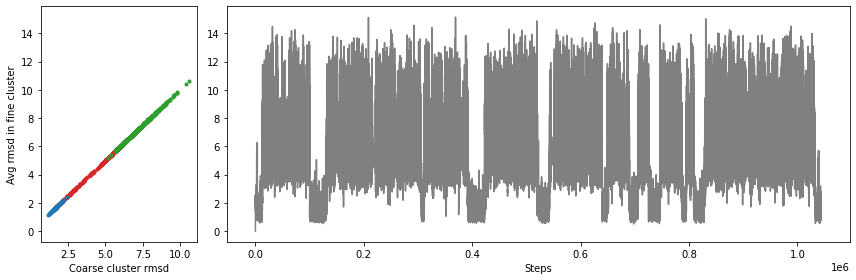

In [227]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(12,4))

ax[0].plot(
    coarse_clustering.cluster_centers[coarse_assignments], 
    avg_state_rmsds[intermediate], 
    '.',
    color='tab:red',)

ax[0].plot(
    coarse_macrostate_clusters['folded'].cluster_centers[
        coarse_macrostate_assignments['folded']], 
    avg_state_rmsds[folded], 
    '.',
    color='tab:blue',)

ax[0].plot(
    coarse_macrostate_clusters['unfolded'].cluster_centers[
        coarse_macrostate_assignments['unfolded']], 
    avg_state_rmsds[unfolded], 
    '.',
    color='tab:green',)

ax[1].plot(rmsd[::rmsd_stride], color='gray', label='RMSD')
ax[1].set_xlabel('Steps')

ax[0].set_ylim(ax[1].get_ylim())

ax[0].set_ylabel('Avg rmsd in fine cluster')
ax[0].set_xlabel('Coarse cluster rmsd')

fig.tight_layout()

In [188]:
assert msm.reversible, "MSM not reversible! Need to symmetrize it."

### Make coarse-mapping convenience objects

We started with `coarse_mapping`, a dictionary where the keys are all of the fine-states, and the values are the coarse-states that each fine-state belongs to.

For convenience, we'll define a couple other things with this same information.

`inv_map` is a dictionary mapping each coarse state to a list of the fine states within it

`cg_map` is a list of length `n_coarse_states`. The `i`th element is a list of the fine-states in coarse state `i`.

In [189]:
inv_map = {}
for k, v in coarse_mapping.items():
    inv_map[v] = inv_map.get(v, []) + [k]

In [190]:
cg_map = [[] for _ in inv_map.keys()]

for k, v in inv_map.items():
    cg_map[k] = v

### Get coarse-grained potential

In [191]:
coarse_distribution.shape

(30,)

In [192]:
coarse_macrostate_clusters['folded'].cluster_centers.flatten()

array([1.39491686, 1.73029713, 2.21006421, 1.55670884, 1.20483531,
       1.98240373, 1.64858503, 2.41518251, 1.50785834, 2.10419453,
       1.85924289, 1.57829802, 1.3074281 , 1.78247392, 1.27255809,
       1.45190883, 1.68659488, 2.14879618, 1.5365508 , 1.34453855,
       1.15445319, 2.02016186, 1.48127628, 1.60746229, 1.76125084,
       1.43434433, 1.70374518, 1.51947721, 2.06824682, 1.81592608,
       1.25623792, 1.37695077, 1.56949652, 1.33061164, 1.66580363,
       2.16970202, 1.41654537, 1.63991499, 1.19104068, 1.52690546,
       1.95881711, 1.54800363, 1.8002499 , 1.47121625, 1.7170129 ,
       1.36215429, 1.74029493, 1.65661281, 1.49854367, 1.59289881])

Text(0, 0.5, '-$\\ln( P^{equil} )$')

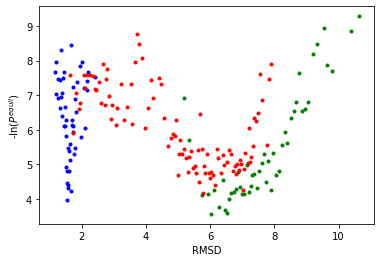

In [228]:
potential = -np.log(msm.stationary_distribution)

coarse_distribution = np.zeros(len(cg_map))
for coarse_state, fine_states in enumerate(cg_map):
    coarse_distribution[coarse_state] = np.sum(msm.stationary_distribution[fine_states])
    
assert np.isclose(sum(coarse_distribution), 1.0), "Coarse distribution not normalized"
coarse_potential = -np.log(coarse_distribution)

    
# plt.plot(
#     avg_state_rmsds[rmsd_sort_order],
#     potential[rmsd_sort_order], '.')

# plt.plot(
#     np.concatenate([coarse_macrostate_clusters['folded'].cluster_centers.flatten(), 
#                     coarse_clustering.cluster_centers.flatten(), 
#                     coarse_macrostate_clusters['unfolded'].cluster_centers.flatten()
#                    ]),
#     coarse_potential, '.')

plt.plot(
    coarse_macrostate_clusters['folded'].cluster_centers.flatten(),
    coarse_potential[range(n_coarse_target_clusters)], 
    'b.')


plt.plot(
    coarse_macrostate_clusters['unfolded'].cluster_centers.flatten(),
    coarse_potential[range(n_coarse_target_clusters + n_coarse_clusters,
                           n_coarse_target_clusters + n_coarse_clusters + 
                               n_coarse_target_clusters)], 
    'g.')

plt.plot(coarse_clustering.cluster_centers.flatten(), 
        coarse_potential[range(n_coarse_target_clusters, 
                               n_coarse_target_clusters + n_coarse_clusters)], 
         'r.')

# plt.axvline(folded_thresh)
# plt.axvline(unfolded_thresh)

plt.xlabel('RMSD')
plt.ylabel('-$\\ln( P^{equil} )$')

## Compute average coarse-state RMSD

In [194]:
avg_coarse_rmsd = np.concatenate([
    coarse_macrostate_clusters['folded'].cluster_centers.flatten(),
    coarse_clustering.cluster_centers.flatten(),
    coarse_macrostate_clusters['unfolded'].cluster_centers.flatten()
])

In [195]:
cg_state_sort = np.argsort(avg_coarse_rmsd)

### Save fine transition matrix and coarse mapping

In [211]:
np.savez(f'{dataset_label}_transition_matrix_nfine{len(msm.transition_matrix)}_ernesto_symm', transition_matrix=msm.transition_matrix,
         states_unfolded = unfolded,
         states_folded = folded,
         fine_clustering = clustering,
         coarse_clustering = coarse_clustering,
         mfpt_folding = mfpt_folding,
         mfpt_unfolding = mfpt_unfolding,
         coarse_mapping = coarse_mapping,
         avg_state_rmsds = avg_state_rmsds,
         coarse_potential = coarse_potential,
         coarse_eq_ref = coarse_distribution,
         cg_state_sort = cg_state_sort,
         avg_coarse_rmsd = avg_coarse_rmsd,
         msm_object=msm,
         coarse_macrostate_clusters=coarse_macrostate_clusters
         )
print(f"Saved to {dataset_label}_transition_matrix_nfine{len(msm.transition_matrix)}_ernesto_symm")

Saved to finer_transition_matrix_nfine1020_ernesto_symm


In [213]:
coarse_macrostate_clusters['folded'].n_clusters

50

In [197]:
coarse_mapping[150]

120

# Sample trajectory generation

Now, we should be able to generate some trajectories from our Markov model.

A couple notes:
- Generated trajectories will have timestep equal to the lag time of the MSM. This is important when compute MFPTs etc
- Generated trajectories are of course in the space of the fine-grained states, and will be coarse-grained after generation

To sanity-check this procedure, I'll generate a large number of trajectories and then verify analyzing them gives me results consistent with the original Markov model.

## Generate fine trajectories

In [198]:
n_trajectories = 50
initial_state = rmsd_sort_order[-1]
traj_seed = 1337
original_trajectory_length=100000
fine_transition_matrix = msm.transition_matrix

In [199]:
# ! Start all in one point
initial_points = np.full(n_trajectories, fill_value=initial_state)
initial_points = np.ones(n_trajectories)
initial_points[:] = initial_state

rng = np.random.default_rng(traj_seed)
# TODO: For large datasets, may not be able to hold this in memory
probs = rng.random(size=(n_trajectories, original_trajectory_length))

fine_trajectories = np.full(shape=(n_trajectories, original_trajectory_length), fill_value=-1, dtype=int)
fine_trajectories[:, 0] = initial_points
for _step in tqdm.tqdm(range(1, original_trajectory_length), desc='Generating trajectories'):
    last_points = fine_trajectories[:, _step - 1]
    next_step_probs = probs[:, _step]

    transition_rows = fine_transition_matrix[last_points]
    prob_sums = np.cumsum(transition_rows, axis=1)

    # Using the probabilities, and the cumulative sums of the transition matrix rows, compute the next state you go to.
    # If you look at one trajectory, this is just looking for the first point where the random number drawn is >= the
    # cumulative probability.
    next_states = np.argmax(
        prob_sums - next_step_probs.reshape((n_trajectories, -1)) >= 0,
        axis=1)

    fine_trajectories[:, _step] = next_states

Generating trajectories:   0%|          | 0/99999 [00:00<?, ?it/s]

In [200]:
fine_trajectories = []

for i in tqdm.tqdm(range(n_trajectories)):
    _traj = msm.simulate(n_steps=original_trajectory_length, start=initial_state)
    fine_trajectories.append(_traj)
    
fine_trajectories = np.array(fine_trajectories)

  0%|          | 0/50 [00:00<?, ?it/s]

## Coarsen trajectories

In [201]:
# Map each fine state to its coarse state, just the inverse of cg_map
fg_map = {y: i for (i, x) in enumerate(cg_map) for y in x}
fine_to_coarse = np.vectorize(lambda x: fg_map[x])
coarse_trajectories = fine_to_coarse(fine_trajectories)

## Plot sample trajectories

Plot a couple trajectories in both the fine- and coarse-grained spaces.

Here, the important thing is that you should be able to see the transitions in/out of the folded/unfolded states in both. Thew intermediate can look messy, but folded/unfolded should be well defined.

Note that here, we're mapping back to average RMSD on the y-axis.

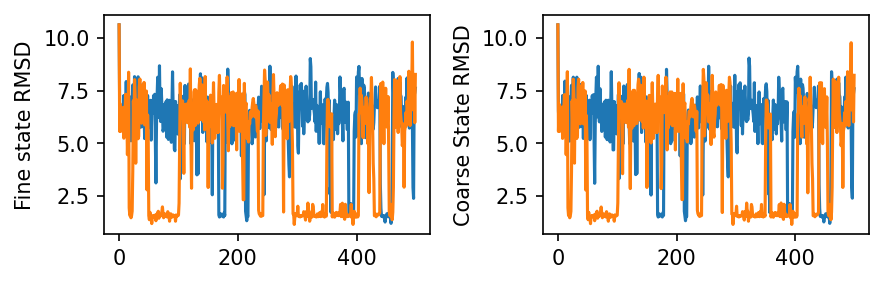

In [229]:
fig, ax  = plt.subplots(1, 2, figsize=(6,2))
rmsd_ax = ax[0]
# fine_ax = ax[1]
coarse_ax = ax[1]
_subsample = 10
latest_point = 5000
for trajectory in fine_trajectories[:2]:
    
    rmsd_trajectory = [avg_state_rmsds[x] for x in trajectory]
    rmsd_ax.plot(rmsd_trajectory[:latest_point:_subsample])
    
    # fine_ax.plot(trajectory[::_subsample])
    
    coarse_traj = fine_to_coarse(trajectory)
    coarse_rmsd_traj = [avg_coarse_rmsd[x] for x in coarse_traj]
    coarse_ax.plot(coarse_rmsd_traj[:latest_point:_subsample])
    
rmsd_ax.set_ylabel('Fine state RMSD')
# fine_ax.set_ylabel('Fine state index')
coarse_ax.set_ylabel('Coarse State RMSD')

# plt.ylim([0, 15])

fig.tight_layout()
fig.set_dpi(150)

## Sanity checks

Let's make sure that analyzing these trajectories gives back results consistent with the Markov model we used to generate them.

In [203]:
lag = msm_lag_steps
print(msm_lag_steps)
check_count_model = TransitionCountEstimator(lag, 'sliding').fit_fetch(fine_trajectories)
check_msm = MaximumLikelihoodMSM().fit_fetch(check_count_model.submodel_largest())

50


It's possible the active set of the MSM built from the generated trajs is smaller than the full set of states.

That's all well and good as far as the eventual analysis, but for sanity checks, go hard on the sampling and make sure all states are represented.

In [204]:
assert check_msm.n_states == msm.n_states

### Compare stationary distributions

This should basically be a diagonal line of slope 1, or else they're giving different stationary distributions.

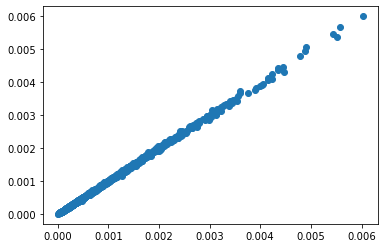

In [230]:
plt.scatter(check_msm.stationary_distribution, msm.stationary_distribution)

### Compare MFPTs

In [206]:
# Remember, trajectories I generate from the MSM are in units of the MSM lag time
check_mfpt_folding = check_msm.mfpt(unfolded.flatten(), folded.flatten()) * msm_lag_steps

In [207]:
check_mfpt_unfolding = check_msm.mfpt(folded.flatten(), unfolded.flatten()) * msm_lag_steps

In [208]:
mfpt_folding, mfpt_unfolding # Folding time, in units of the input trajectory

(51138.754251981, 11599.601489364708)

In [209]:
check_mfpt_folding, check_mfpt_unfolding # Folding time, in units of the input trajectory

(59046.44079925745, 15687.514607360845)

In [232]:
# OG MSM
print("--- Original MSM ---")
print(f"Folding time: \t{mfpt_folding * universe.trajectory.dt * stride / 1000:.2f} ns")
print(f"Folding steps: \t{mfpt_folding :.0f} steps\n")

print(f"Unfolding time: \t{mfpt_unfolding * universe.trajectory.dt * stride  / 1000:.2f} ns")
print(f"Unfolding steps: \t{mfpt_unfolding :.0f} steps")


print("\n--- MSM from generated trajectories ---")

print(f"Folding time: \t{check_mfpt_folding * universe.trajectory.dt / 1000:.2f} ns")
print(f"Folding steps: \t{check_mfpt_folding / msm_lag_steps :.0f} steps\n")

print(f"Unfolding time: \t{check_mfpt_unfolding * universe.trajectory.dt  / 1000:.2f} ns")
print(f"Unfolding steps: \t{check_mfpt_unfolding / msm_lag_steps:.0f} steps")

--- Original MSM ---
Folding time: 	10227.75 ns
Folding steps: 	51139 steps

Unfolding time: 	2319.92 ns
Unfolding steps: 	11600 steps

--- MSM from generated trajectories ---
Folding time: 	11809.29 ns
Folding steps: 	1181 steps

Unfolding time: 	3137.50 ns
Unfolding steps: 	314 steps
